[View in Colaboratory](https://colab.research.google.com/github/samsam915/practice/blob/master/mnist_tensorboard.ipynb)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.1
step 100, training accuracy 0.84
step 200, training accuracy 0.92
step 300, training accuracy 0.94
step 400, training accuracy 0.95
step 500, training accuracy 0.94
step 600, training accuracy 0.95
step 700, training accuracy 0.96
step 800, training accuracy 0.94
step 900, training accuracy 0.97
step 1000, training accuracy 0.97
step 1100, training accuracy 0.98
step 1200, training accuracy 0.99
step 1300, training accuracy 0.99
step 1400, training accuracy 1
step 1500, training accuracy 0.99
step 1600, training accuracy 0.99
step 1700, training accuracy 0.98
step 1800, training accuracy 0.97
step 1900, training accuracy 0.99
step 2000, training accuracy 0.98
step 2100, training accuracy 0.96
step 2200, training accuracy 0.98
step 2300, training accuracy 0.99
step 2

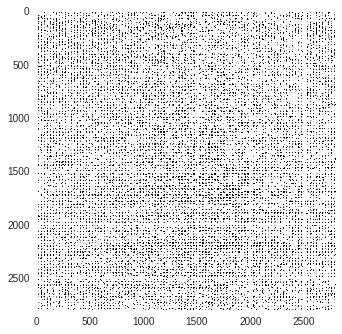

In [3]:

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import os 
from tensorflow.contrib.tensorboard.plugins import projector
#导入数据
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

DIR_log = 'mnist'
niter = 5000
test_interval = 100

if not os.path.exists(DIR_log):
    os.mkdir(DIR_log)
    
#初始化权重
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

#初始化偏差
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

#卷积层
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#池化层
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#生成全景图像文件。
#tensorboard可以从全景图中按序裁剪出每一幅手写体图像，在页面上独立渲染。
def create_sprite_image(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_mnist(mnist_digits):
    return np.reshape(mnist_digits,(-1,28,28))

def invert_grayscale(mnist_digits):
    return 1-mnist_digits

to_visualise = (mnist.test.images[:10000])
to_visualise = vector_to_matrix_mnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.imsave(os.path.join(DIR_log,'mnist_10k_sprite.png'),sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')
    
with tf.Graph().as_default() as graph:

    #载入图片    
    embedding_var = tf.Variable(tf.stack(mnist.test.images[:10000]),trainable=False,name='embedding')

    #模型输入
    with tf.name_scope('intput'):
        xs = tf.placeholder(tf.float32, [None, 784],name='x')     
        ys = tf.placeholder(tf.float32, [None, 10],name='y')      
    
    
    with tf.name_scope('conv1'):
        #[n_samples,28*28]的一维向量转为[n_samples,28,28,1]的图像
        x_image = tf.reshape(xs, [-1, 28, 28, 1])
        tf.summary.image('input', x_image, 10)

        ##第一层卷积和池化
        #输入尺寸[n_samples,28,28,1]
        #输出尺寸[n_samples,14,14,32]
        W_conv1 = weight_variable([5,5, 1,32])     
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) 
        h_pool1 = max_pool_2x2(h_conv1)                          

        #数据分布图
        tf.summary.histogram('W_con1',W_conv1)
        tf.summary.histogram('b_con1',b_conv1)
    
    with tf.name_scope('conv1'):
        ##第二层卷积层和池化层
        #输入尺寸[n_samples,14,14,32]
        #输出尺寸[n_samples,7,7,64]
        W_conv2 = weight_variable([5,5, 32, 64]) 
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) 
        h_pool2 = max_pool_2x2(h_conv2)                 

        #数据分布图
        tf.summary.histogram('W_con2', W_conv2)
        tf.summary.histogram('b_con2', b_conv2)
    
    with tf.name_scope('fc1'):
        #转换为[n_samples,7*7*64]的一维向量
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])  

        #全连接层fc1
        W_fc1 = weight_variable([7*7*64, 1024])
        b_fc1 = bias_variable([1024])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #数据分布图
        tf.summary.histogram('W_fc1', W_fc1)
        tf.summary.histogram('b_fc1', b_fc1)
    
        #dropout
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    with tf.name_scope('fc2'):
        #计算概率输出
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

        #数据分布图
        tf.summary.histogram('W_fc1', W_fc2)
        tf.summary.histogram('b_fc1', b_fc2)
        
    with tf.name_scope('train'):
        #交叉熵损失
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(pred),reduction_indices=[1]))      

        #优化器
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

        #精确度
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(ys, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        #添加获取交叉熵的汇总操作
        tf.summary.scalar('loss',cross_entropy)
        ##添加获取准确率的汇总操作
        tf.summary.scalar('accuracy',accuracy)
        
    #创建元数据文件，将嵌入变量保存到checkpoint文件中
    metadata_file = os.path.join(DIR_log,'metadata.tsv')
    
    with open(metadata_file,'w') as f:
        for i in  range(1000):
            c = np.nonzero(mnist.test.labels[::1])[1:][0][i]
            f.write('{}\n'.format(c))
    
    #合并所有的summary
    merged = tf.summary.merge_all()
    
    #创建投影配置参数
    projector_writer = tf.summary.FileWriter(DIR_log)
    config = projector.ProjectorConfig()
    embeddings = config.embeddings.add()
    embeddings.tensor_name = embedding_var.name
    embeddings.metadata_path = 'metadata.tsv'
    
    #设置全景图文件路径和手写体数字图像的尺寸
    embeddings.sprite.image_path = os.path.join('mnist_10k_sprite.png')
    embeddings.sprite.single_image_dim.extend([28,28])
    #执行可视化方法，讲参数配置写入新传概念的投影配置文件中
    #tensorboard启动时会自动加载该文件中的投影参数配置
    projector.visualize_embeddings(projector_writer,config)
    

#定义一个会话
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    #开始训练
    for i in range(niter):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})
        #train_loss_list.append(loss)
        if i % test_interval == 0:
            train_accuracy = sess.run(accuracy, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 1.0})
            #accuracy_list.append(train_accuracy)
            summary = sess.run(merged,feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 1.0})
            projector_writer.add_summary(summary,i+1)
            print( "step %d, training accuracy %g" % (i, train_accuracy))
    saver.save(sess, os.path.join(DIR_log,"model.cpkt"),i)  
    
    print ("test accuracy %g" % sess.run(accuracy, feed_dict={xs : mnist.test.images, ys: mnist.test.labels, keep_prob: 1.0}))
    print("DONE")



In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = 'mnist'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


Redirecting output to ‘wget-log’.
Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://ca97a0b4.ngrok.io


Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [4]:
LOG_DIR = 'mnist'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://27985352.ngrok.io
